## Исследуем файл train

#### 1. Готовим данные

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [35]:
train = pd.read_csv('train.csv',
                   usecols=[1, 2, 3, 4, 5, 6, 7, 8, 9],
                   dtype={
                          'timestamp': 'int32',
                          'user_id': 'int32',
                          'content_id': 'int16',
                          'content_type_id': 'int8',
                          'task_container_id': 'int16',
                          'user_answer': 'int8',
                          'answered_correctly':'int8',
                          'prior_question_elapsed_time': 'float32',
                          'prior_question_had_explanation': 'boolean'
                          },
                   )
# считали файл в Dateframe, сократили объем за счет изменения типов данных и удаления столбца 1, совпадающего с индексом

In [5]:
train # проверили корректность считывания файла по исходным данным

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,0,1,3,1,NaN,<NA>
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...
101230327,428564420,2147482888,3586,0,22,0,1,18000.0,True
101230328,428585000,2147482888,6341,0,23,3,1,14000.0,True
101230329,428613475,2147482888,4212,0,24,3,1,14000.0,True
101230330,428649406,2147482888,6343,0,25,1,0,22000.0,True


Файл представляет собой описание всех событий взаимодействия пользователей с платформой (101,2 млн событий).

#### 2. Получаем общие сведения о файле и данных

In [25]:
train.info()  # узнали наименования, типы столбцов и размер файла

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int32  
 1   user_id                         int32  
 2   content_id                      int16  
 3   content_type_id                 int8   
 4   task_container_id               int16  
 5   user_answer                     int8   
 6   answered_correctly              int8   
 7   prior_question_elapsed_time     float32
 8   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), int16(2), int32(2), int8(3)
memory usage: 2.0 GB


Имея названия столбцов, проанализируем взаимосвязи между показателями

In [3]:
print(f'Количество уникальных пользователей - {train.user_id.nunique()}')

Количество уникальных пользователей - 393656


In [8]:
print(f'В базе train имеется {train.content_id.nunique()} видов контента, из которых {train[train.content_type_id == False].content_id.nunique()} вопросов.')

В базе train имеется 13782 видов контента, из которых 13523 вопросов.


In [3]:
print(f'В базе train имеется {train.task_container_id.nunique()} уникальных пакетов вопросов или лекций.')

В базе train имеется 10000 уникальных пакетов вопросов или лекций.


#### 3. Проанализируем влияние контента на успеваемость

In [6]:
# всего получено ответов по типам заданий, где 0 - вопросы, 1 - лекции
train.content_type_id.value_counts()

0    99271300
1     1959032
Name: content_type_id, dtype: int64

Было получено ответов на вопросы - 99,2 млн, просмотров лекций - 1,95 млн.

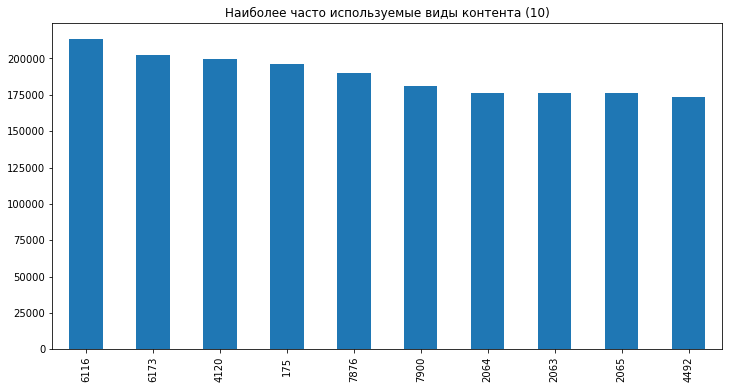

In [4]:
# виды контента
cids = train.content_id.value_counts()[:10]

fig = plt.figure(figsize=(12,6))
ax = cids.plot.bar()
plt.title("Наиболее часто используемые виды контента (10)")
plt.xticks(rotation=90)
plt.show()

Максимальное количество ответов получено на задание 6116 - более 200 тыс. операций.

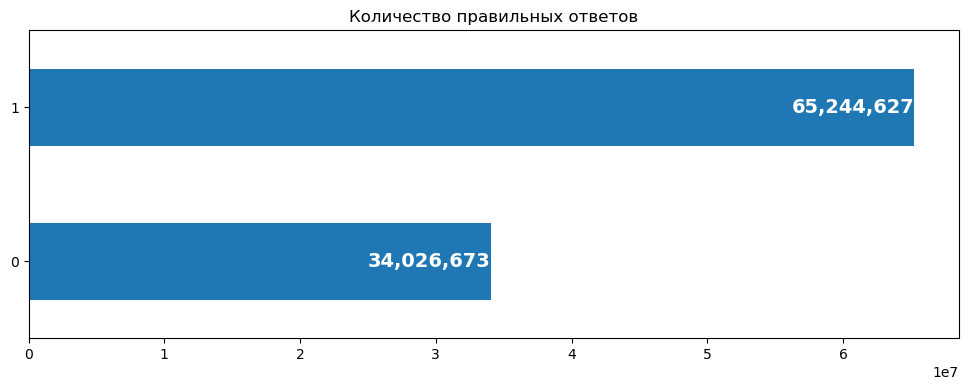

In [5]:
# получено правильных ответов, исключая лекции (-1) 
correct = train[train.answered_correctly != -1].answered_correctly.value_counts(ascending=True)

fig = plt.figure(figsize=(12,4))
correct.plot.barh()
for i, v in zip(correct.index, correct.values):
    plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Количество правильных ответов")
plt.xticks(rotation=0)
plt.show()

Из 99 млн операций примерно в 2/3 случаях пользователи дали правильные ответы, в 1/3 случаев - неправильные.

#### 4. Проанализируем связь между длительностью обучения и правильностью ответов

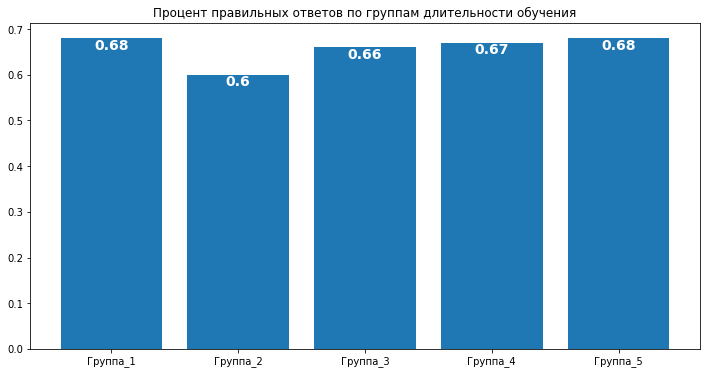

In [6]:
# разобьем пользователей на 5 групп по времени пребывания на платформе (timestamp) 

bin_labels_5 = ['Группа_1', 'Группа_2', 'Группа_3', 'Группа_4', 'Группа_5']
train['ts_bin'] = pd.qcut(train['timestamp'], q=5, labels=bin_labels_5)

# правильные ответы, кроме лекций
def correct(field):
    correct = train[train.answered_correctly != -1].groupby([field, 'answered_correctly'], as_index=False).size()
    correct = correct.pivot(index= field, columns='answered_correctly', values='size')
    correct['Процент правильных ответов'] = round(correct.iloc[:,1]/(correct.iloc[:,0] + correct.iloc[:,1]),2)
    correct = correct.sort_values(by = "Процент правильных ответов", ascending = False)
    correct = correct.iloc[:,2]
    return(correct)

bins_correct = correct("ts_bin")
bins_correct = bins_correct.sort_index()

fig = plt.figure(figsize=(12,6))
plt.bar(bins_correct.index, bins_correct.values)
for i, v in zip(bins_correct.index, bins_correct.values):
    plt.text(i, v, v, color='white', fontweight='bold', fontsize=14, va='top', ha='center')
plt.title("Процент правильных ответов по группам длительности обучения")
plt.xticks(rotation=0)
plt.show()

При автоматическим разбиении всех пользователей на 5 групп по длительности пребывания на платформе, процент правильных ответов минимален у тех, кто провел некоторое время на платформе и вначале отвечал хорошо. Причины могут быть следующие: (1) в начале обучения студент склонен внимательно вчитываться в вопрос и старается не совершать ошибок, а потом расслабляется; (2) последующие задания более сложные, а первые более легкие, чтобы простимулировать студентов к обучению.

#### 5. Процент правильных ответов по блокам заданий (task_conteiner)

Последующие исследования выполнены на сокращенной базе train (1 млн операций), поскольку на моем компьютере не хватает памяти.

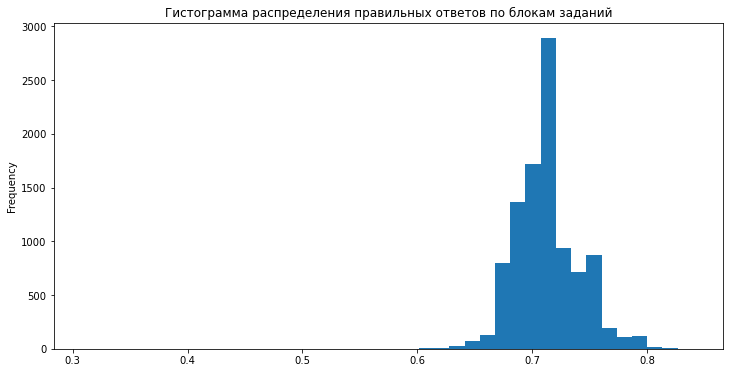

In [8]:
task_id_correct = correct("task_container_id"[:1000000])

fig = plt.figure(figsize=(12,6))
task_id_correct.plot.hist(bins=40)
plt.title("Гистограмма распределения правильных ответов по блокам заданий")
plt.xticks(rotation=0)
plt.show()

Гистограмма правильных ответов отличается от нормальной, возможно, из-за ограниченного объема выборки.

#### 6. Зависимость правильного ответа от объяснений по предыдущему вопросу

prior_question_had_explanation
False     86390
True     889887
Name: (answered_correctly, count), dtype: int64


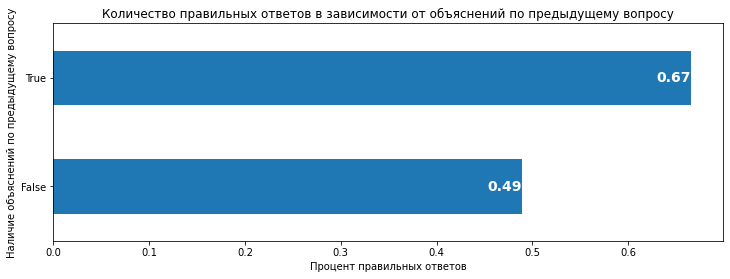

In [18]:
train1 = train[:1000000]
pq = train1[train1.answered_correctly != -1].groupby(['prior_question_had_explanation'], dropna=True).agg({'answered_correctly': ['mean', 'count']})
#pq.index = pq.index.astype(str)
print(pq.iloc[:,1])
pq = pq.iloc[:,0]

fig = plt.figure(figsize=(12,4))
pq.plot.barh()
for i, v in zip(pq.index, pq.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Количество правильных ответов в зависимости от объяснений по предыдущему вопросу")
plt.xlabel("Процент правильных ответов")
plt.ylabel("Наличие объяснений по предыдущему вопросу")
plt.xticks(rotation=0)
plt.show()

При наличии объяснений по предыдущему вопросу процент правильных ответов примерно в 1,4 раза выше.

#### 7. Корреляция между средним временем ответа на предыдущий пакет вопросов и правильным ответом на последующий вопрос

In [33]:
pq = train['prior_question_elapsed_time'].corr(train['answered_correctly'])
print(pq)

-0.007900239787032533


Корреляция слабая, время ответа на текущий вопрос не зависит от времени, затраченного на предыдущий пакет вопросов

## Исследуем файл questions

In [11]:
questions = pd.read_csv('questions.csv')
questions

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


Видим, что имеется 13522 вида вопросов и 13522 вида пакета вопросов в 5 частях теста. Для некоторых вопросов указано несколько тегов, для други - только один.

In [4]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


В колонке tags имеется объект NaN.

#### 2. Исследуем значение тегов

In [5]:
questions['tags'] = questions['tags'].astype(str)

tags = [x.split() for x in questions[questions.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)
print(f'Имеется {len(tags)} различных тэгов.')

Имеется 188 различных тэгов.


In [10]:
tags_list = [x for x in questions.tags.values]
questions['tags'] = tags_list
questions.head()

correct = train[train.answered_correctly != -1].groupby(["content_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "content_id", columns='answered_correctly', values='size')
correct.columns = ['Wrong', 'Right']
correct = correct.fillna(0)
correct[['Wrong', 'Right']] = correct[['Wrong', 'Right']].astype(int)
questions = questions.merge(correct, left_on = "question_id", right_on = "content_id", how = "left")
questions

,question_id,bundle_id,correct_answer,part,tags,Wrong,Right
0,0,0,0,1,51 131 162 38,637,6266
1,1,1,1,1,131 36 81,809,6589
2,2,2,0,1,131 101 162 92,20015,24890
3,3,3,0,1,131 149 162 29,5067,17906
4,4,4,3,1,131 5 162 38,12275,19461
...,...,...,...,...,...,...,...
13518,13518,13518,3,5,14,185,683
13519,13519,13519,3,5,8,396,528
13520,13520,13520,2,5,73,282,579
13521,13521,13521,0,5,125,167,703


## Исследуем файл lectures

In [26]:
import numpy as np

#### 1. Общие сведения

In [16]:
lectures = pd.read_csv('lectures.csv')
lectures

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
...,...,...,...,...
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept


In [20]:
print(f'На платформе размещено {lectures.shape[0]} лекций.')

На платформе размещено 418 лекций.


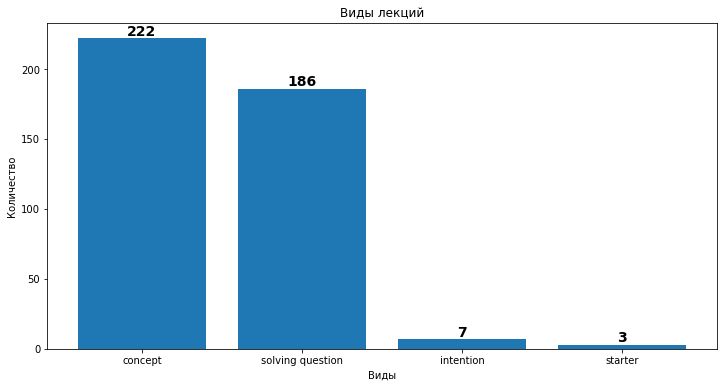

In [22]:
lect_type_of = lectures.type_of.value_counts()

fig = plt.figure(figsize=(12,6))
plt.bar(lect_type_of.index, lect_type_of.values)
for i, v in zip(lect_type_of.index, lect_type_of.values):
    plt.text(i, v, v, color='black', fontweight='bold', fontsize=14, va='bottom', ha='center')
plt.title("Виды лекций")
plt.xlabel("Виды")
plt.ylabel("Количество")
plt.xticks(rotation=0)
plt.show()

#### 2. Проанализируем, как влияет просмотр лекций на правильность ответов

False    244050
True     149606
Name: Watches_lecture, dtype: int64


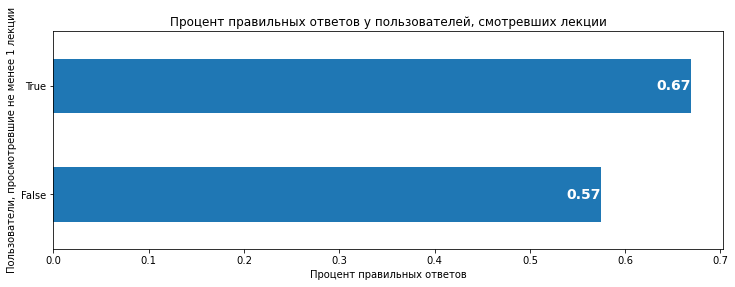

In [25]:
user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', 'Right']
user_lect['Lecture'] = user_lect['Lecture'].fillna(0)
user_lect = user_lect.astype('Int64')
user_lect['Watches_lecture'] = np.where(user_lect.Lecture > 0, True, False)

watches_l = user_lect.groupby("Watches_lecture").agg({'Wrong': ['sum'], 'Right': ['sum']})
print(user_lect.Watches_lecture.value_counts())

watches_l['Percent_correct'] = watches_l.Right/(watches_l.Right + watches_l.Wrong)

watches_l = watches_l.iloc[:,2]

fig = plt.figure(figsize=(12,4))
watches_l.plot.barh()
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("Процент правильных ответов у пользователей, смотревших лекции")
plt.xlabel("Процент правильных ответов")
plt.ylabel("Пользователи, просмотревшие не менее 1 лекции")
plt.xticks(rotation=0)
plt.show()

Видим, что просмотр лекций влияет на правильность ответов, но не слишком существенно.

## Выводы:

Исследуются события взаимодействия 393 тыс. пользователей с образовательной платформой (101,2 млн событий).
На платформе представлено 13523 вопроса, объединенных в 10000 пакетов.

Было получено ответов на вопросы - 99,2 млн, просмотров лекций - 1,95 млн, т.е. в среднем на студента приходится 252 ответа на вопросы и 5 просмотров лекций. При этом на некоторые виды вопросов было получено до 200 тыс. ответов.
Из 99 млн операций примерно в 2/3 случаях пользователи дали правильные ответы, в 1/3 случаев - неправильные.

При автоматическим разбиении всех пользователей на 5 групп по длительности пребывания на платформе, процент правильных ответов минимален у 2 группы (тех, кто провел некоторое время на платформе и вначале отвечал хорошо). Причины могут быть следующие: (1) в начале обучения студент склонен внимательно вчитываться в вопрос и старается не совершать ошибок, а потом расслабляется; (2) последующие задания более сложные, а первые даются полегче, чтобы простимулировать студентов к обучению.

К сожалению, не удалось в полном объеме проанализировать распределение правильных ответов, которое отличается от нормального, по причине ограничений памяти. Особенный интерес представляет правильность ответов по видам контента.

При наличии объяснений по предыдущему пакету вопросов процент правильных ответов примерно в 1,4 раза выше.

Наблюдается довольно слабая корреляция между временем ответа на текущий вопрос и временем, затраченным на предыдущий пакет вопросов, что говорит о разнообразии вопросов.

Имеется 188 различных тегов вопросов, которые могут относиться как к одному вопросу, так и к нескольким. К сожалению, значения тегов в описании не приводятся.

На платформе размещено 418 лекций 4 видов: объяснение, семинар, постановка целей и вводные. Несмотря на то, что объяснения и семинары составляют подавляющее большинство лекций (97,6%), просмотр лекций не слишком влияет на правильность ответов.

Таким образом, исходя из проанализированных признаков, на успеваемость положительно влияют следующие факторы:
- время на платформе; 
- пояснения по предыдущему пакету вопросов, но не лекции/семинары.

Для повышения успеваемости предположительно нужно удерживать пользователя на платформе для роста процента правильных ответов; давать пояснения по пакетам вопросов; сгладить сложность вопросов в 1 и последующих группах во избежание потери мотивации.
